### 导入依赖包

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from skimage.feature import hog
from skimage import exposure
from skimage.transform import rotate
import pickle
from tqdm import tqdm
import timeit
from joblib import Parallel, delayed
import os
%matplotlib inline

### 读取csv文件并返回像素值和标签

In [5]:
def read_file(filename):

    #读取文件数据，数据含有标签值，将直接载入图像的直方图，一个向量有256个元素
    df = pd.read_csv(filename)

    pixels = df.drop(columns=['label']).values

    labels = df.label.values
    pixels = pixels.astype(np.float64)
    return pixels, labels

### 加载保存数据

In [6]:
def save_pickle(data, filename):
    # 序列化对象，将对象object保存到文件file中
    pickle.dump(data, open(filename, 'wb'))

def load_pickle(filename):
    # 反序列化对象，将文件中的数据解析为一个python对象
    return pickle.load(open(filename, 'rb'))

### 显示手势图像

In [7]:
def show_image(pixels, labels, numbers=24, img_size=28):

    new_pixels = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))
    
    #对集合进行去重处理
    label_set = set(np.unique(y_train))

    n_images = len(pixels)
    n_label = len(label_set)
    label_ = set()
    num = 0
    while num < numbers:
        idx = np.random.randint(0, n_images)
        if labels[idx] in label_set and (labels[idx] not in label_ or num >= n_label):
            num += 1
            label_.add(labels[idx])
            plt.subplot(numbers // 4 + 1, 4, num)
            plt.axis('off')
            plt.title(labels[idx])
            plt.imshow(new_pixels[idx, :, :, 0], cmap='gray')

    plt.show()

## 读取数据并展示

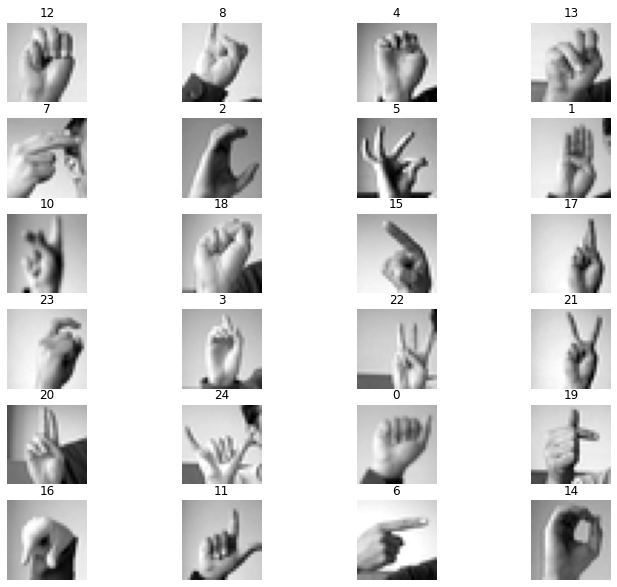

In [8]:
trainSet_path = "D:/Bingo/archive/sign_mnist_train/sign_mnist_train.csv"
testSet_path = "D:/Bingo/archive/sign_mnist_test/sign_mnist_test.csv"
X_train, y_train = read_file(trainSet_path)
X_test, y_test = read_file(testSet_path)

# 进行归一化 
X_train /= 255
X_test /= 255

#显示手势图像
show_image(X_train, y_train)

### Baseline

In [94]:
# 训练基线模型
start = timeit.default_timer()

'''
该数据集明显不适合使用线性回归，采用逻辑回归算法进行训练
liblinear：使用了开源的liblinear库实现，内部使用了坐标轴下降法来迭代优化损失函数。
lbfgs: 拟牛顿法的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。
newton-cg：也是牛顿法家族的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。
sag：即随机平均梯度下降，是梯度下降法的变种，和普通梯度下降法的区别是每次迭代仅仅用一部分的样本来计算梯度，适合于样本数据多的时候。
saga：线性收敛的随机优化算法的的变重。
'''
model = LogisticRegression(max_iter=10000, solver='lbfgs', multi_class='auto')
#使用五折交叉验证进行评估
scores = cross_val_score(model, X_train, y_train, cv=5)

end = timeit.default_timer()
print("Fit time:", end - start)
print("Valificasion: %.2f" % (scores.mean() * 100))

Fit time: 556.8851403000008
Valificasion: 99.96


### 特征工程之特征提取:使用方向梯度直方图

In [9]:
def extract_hog(img, img_size=28, orientations=9, pixels_per_cell=(2, 4), cells_per_block=(4, 3)):

    fd = hog(img.reshape((img_size, img_size)), orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=False)
    return fd

def parallel_extraction(images):
    
    # Parallel函数会创建一个进程池，以便在多进程中执行每一个列表项，设置参数n_jobs，即开启n_jobs个进程。
    features = Parallel(n_jobs=os.cpu_count())(delayed(extract_hog)(img) for img in tqdm(images))
    return np.array(features)

In [10]:
# 使用方向梯度直方图构造特征
X_train_hog = parallel_extraction(X_train)
X_test_hog = parallel_extraction(X_test)

100%|████████████████████████████████████████████████████████████████████████████| 7172/7172 [00:06<00:00, 1156.29it/s]


In [101]:
# 使用新特征训练模型
start = timeit.default_timer()

model = LogisticRegression(max_iter=10000, solver='lbfgs', multi_class='auto')
model.fit(X_train_hog, y_train)

end = timeit.default_timer()
#计算拟合时间
print("Fit time:", end - start)

y_pred = model.predict(X_test_hog)
print("Accuracy: %.2f" % (accuracy_score(y_test, y_pred) * 100))

Fit time: 127.00558940000337
Accuracy: 92.67


### 评估新模型

In [111]:
# 准确率
accuracy_score_value = accuracy_score(y_test, y_pred)
print(f"准确率:{accuracy_score_value}")


confusion_matrix_value = confusion_matrix(y_test, y_pred)
print(f"混淆矩阵:\n{confusion_matrix_value}")

report = classification_report(y_test, y_pred)
print(f"分类报告:\n{report}")


准确率:0.9266592303402119
混淆矩阵:
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 411   0   0   0   0   0   0   0  21   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 309   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 245   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 498   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   3   0   0 244   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 307  20   0   0   2   0   0   0   0   0   0   0
   19   0   0   0   0   0]
 [  0   0   0   0   0   0  20 416   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0 249   0   6   0   0   0   0   0   0   6
    0   0   0   0   0  15]
 [  0   0   0   6   0   0   0   0   0 301   0   0   0   0   1 

### 寻找更好的模型参数

In [78]:
# 设置超参数
params = []
for n_component in np.arange(300, 1000, 50):
    for C_value in np.logspace(-3, 3, 7):
        params.append({
        "pca__n_components" : n_component,
        "clf__estimator__C" : C_value 
        })

best_score = 0
best_param = None

# 循环寻找最好的拟合参数
for param in params:
    pipeline = Pipeline([
                      ('pca', PCA()),
                      ('clf', OneVsOneClassifier(
                          LogisticRegression(max_iter=10000, solver='lbfgs', multi_class='auto'))
                      )
    ])

    pipeline.set_params(**param)
    start = timeit.default_timer()
    pipeline.fit(X_train_hog, y_train)
    stop = timeit.default_timer()
    print("=============")
    print("Parameter", param)
    print("Training time: %.2f" % (stop - start))
    current_score = pipeline.score(X_test_hog, y_test)
    print("Accuracy: %.2f" % (current_score * 100))
    if current_score > best_score:
        best_param = param
        best_score = current_score

print("Best parameter:", best_param)

Param {'pca__n_components': 300, 'clf__estimator__C': 0.001}
Training time: 29.96
Accuracy: 80.97
Param {'pca__n_components': 300, 'clf__estimator__C': 0.01}
Training time: 34.98
Accuracy: 90.38
Param {'pca__n_components': 300, 'clf__estimator__C': 0.1}
Training time: 32.68
Accuracy: 91.82
Param {'pca__n_components': 300, 'clf__estimator__C': 1.0}
Training time: 31.36
Accuracy: 92.09
Param {'pca__n_components': 300, 'clf__estimator__C': 10.0}
Training time: 30.39
Accuracy: 92.25
Param {'pca__n_components': 300, 'clf__estimator__C': 100.0}
Training time: 32.00
Accuracy: 92.48
Param {'pca__n_components': 300, 'clf__estimator__C': 1000.0}
Training time: 30.68
Accuracy: 92.57
Param {'pca__n_components': 350, 'clf__estimator__C': 0.001}
Training time: 31.97
Accuracy: 81.34
Param {'pca__n_components': 350, 'clf__estimator__C': 0.01}
Training time: 34.45
Accuracy: 90.69
Param {'pca__n_components': 350, 'clf__estimator__C': 0.1}
Training time: 33.81
Accuracy: 91.52
Param {'pca__n_components': 

Accuracy: 92.72
Param {'pca__n_components': 800, 'clf__estimator__C': 10.0}
Training time: 63.87
Accuracy: 93.06
Param {'pca__n_components': 800, 'clf__estimator__C': 100.0}
Training time: 63.62
Accuracy: 93.14
Param {'pca__n_components': 800, 'clf__estimator__C': 1000.0}
Training time: 62.65
Accuracy: 93.32
Param {'pca__n_components': 850, 'clf__estimator__C': 0.001}
Training time: 59.72
Accuracy: 82.25
Param {'pca__n_components': 850, 'clf__estimator__C': 0.01}
Training time: 60.90
Accuracy: 91.01
Param {'pca__n_components': 850, 'clf__estimator__C': 0.1}
Training time: 63.84
Accuracy: 92.04
Param {'pca__n_components': 850, 'clf__estimator__C': 1.0}
Training time: 67.57
Accuracy: 92.65
Param {'pca__n_components': 850, 'clf__estimator__C': 10.0}
Training time: 70.14
Accuracy: 93.06
Param {'pca__n_components': 850, 'clf__estimator__C': 100.0}
Training time: 69.51
Accuracy: 93.15
Param {'pca__n_components': 850, 'clf__estimator__C': 1000.0}
Training time: 68.53
Accuracy: 93.39
Param {'p

C=1000 , PCA_n_components=950 时，Accuracy最高为93.42

### 最终使用的模型

In [11]:
 CONFIGS = {
    'C' : 1000,
    'MAX_ITER' : 10000,
    'N_COMPONENTS' : 950,
}

def train(X_train, y_train, model=None):

    X_train = parallel_extraction(X_train)

    print("***** TRAINING *****")
    if model is None:
        print("Initializing model")
        model = Pipeline([
                            ('pca', PCA(n_components=CONFIGS['N_COMPONENTS'])),
                            ('clf', OneVsOneClassifier(
                                LogisticRegression(C=CONFIGS['C'], 
                                                   max_iter=CONFIGS['MAX_ITER'], 
                                                   solver='lbfgs', multi_class='auto')))
        ])

    print("Training model")
    model.fit(X_train, y_train)

    print("Finished training model")
    return model

def predict(X_test, y_test, model=None):
    
    X_test = parallel_extraction(X_test)

    print("***** PREDICTION *****")
    if model is None: 
        print("Start loading model")
        model = load_pickle(CONFIGS['MODEL_PATH'])

    print("Predicting")
    y_pred = model.predict(X_test)

    print("Scoring model")
    missed_labels = np.sum(y_pred != y_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy: {:.4f}".format(accuracy))
    print("Missed Label: ", missed_labels)

    print("Finished predicting model!")
    return y_pred


### 训练与评估

In [13]:
# 读取数据
X_train, y_train = read_file(trainSet_path)
X_test, y_test = read_file(testSet_path)

# 给定的像素的灰度值在0-255，为了使模型的训练效果更好，将数值归一化映射到0-1 
X_train /= 255
X_test /= 255

# 训练模型
model = train(X_train, y_train)

# 使用测试集进行预测
y_pred = predict(X_test, y_test, model)

100%|██████████████████████████████████████████████████████████████████████████| 27455/27455 [00:17<00:00, 1556.95it/s]


***** TRAINING *****
Initializing model
Training model


  0%|                                                                                         | 0/7172 [00:00<?, ?it/s]

Finished training model


100%|████████████████████████████████████████████████████████████████████████████| 7172/7172 [00:05<00:00, 1249.48it/s]


***** PREDICTION *****
Predicting
Scoring model
Accuracy: 0.9340
Missed Label:  473
Finished predicting model!


### 评估

In [15]:
# 准确率
accuracy_score_value = accuracy_score(y_test, y_pred)
print(f"准确率:{accuracy_score_value}")


confusion_matrix_value = confusion_matrix(y_test, y_pred)
print(f"混淆矩阵:\n{confusion_matrix_value}")

report = classification_report(y_test, y_pred)
print(f"分类报告:\n{report}")


准确率:0.9340490797546013
混淆矩阵:
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 411   0   0   0   0   0   0   0  21   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 310   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 241   0   0   0   0   0   0   0   0   0   0   0   0   0   4
    0   0   0   0   0   0]
 [  0   0   0   0 498   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 247   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 311  19   0   0   0   0   0   0   0   0   0   0
   18   0   0   0   0   0]
 [  0   0   0   0   0   0  20 416   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 268   0   0   0   0   0   0   0   0   0
    0   0   0   0   0  20]
 [  0   0   0   0   0   0   0   0   0 282   0   0   0   0   0 

### 存储预测结果

In [20]:
df = pd.DataFrame()
df['y_true'] = y_test
df['y_pred'] = y_pred
df.to_csv("./predict_result.csv", index = False)

### 将预测结果上传到s3

In [21]:
import boto3
from botocore.client import Config

access_key = ''  # access_key
secret_key = '' # secret_key
host=''    # endpoint
bucket_name = 'work4'  # 存储桶名字
local_file_path = 'Jupyter/predict_result.csv'   # 要上传的文件路径
key_name = 'predict_result.csv'   # 存储在桶中的key

s3 = boto3.client('s3',
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_key,
    endpoint_url=host,
   config=Config(signature_version='s3'),
    region_name='cn-north-1')


In [23]:
s3.put_object(Bucket = bucket_name,Body = local_file_path, Key = key_name, ACL='public-read')

{'ResponseMetadata': {'RequestId': 'tx00000000000000004d3a0-0060d2e201-10af8060-default',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-length': '0',
   'etag': '"94ce1ee1144d05f534691fa9b0c2be93"',
   'accept-ranges': 'bytes',
   'server': 'BingoCloudS3 2.2.0',
   'x-amz-request-id': 'tx00000000000000004d3a0-0060d2e201-10af8060-default',
   'date': 'Wed, 23 Jun 2021 07:25:53 GMT',
   'connection': 'Keep-Alive'},
  'RetryAttempts': 0},
 'ETag': '"94ce1ee1144d05f534691fa9b0c2be93"'}